In [1]:
%pip install plotly


[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import distributions
import datetime
import pandas as pd
import pandas_datareader.data as pdr
from options_chains import OptionsChain
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, GRU

Because the LSTM model doesn't have an in-built parameter to model the volatility^2 (variance) of the returns, two LSTM Models will be made per security, one to model the mean of the returns, and the other to model the volatility of the returns. These can then be used to simulate returns of the security with the hypothesis that the returns are normally distributed around the expected return $r$ with volatility^2 $v^2$ such that the return at timestep $r_i$ is modelled with $r_i \sim N(r, v^2)$. 

These simulations are then used to form a monte-carlo estimation of the value of a given option. 

This is done because there is no analytical equation to price the option using only the expected return and volatility when these values are changing across the lifetime of the option.

In [ ]:
"""
Making training, and testing datasets
Training set is SPY returns from 2014
Testing set is SPY returns in 2019 
"""
split_date = "2019-01-01"
spy_returns = distributions.get_returns(["SPY"], "2014-01-01", "2020-01-01")
spy_data = pd.DataFrame({"Log Returns":spy_returns})
spy_data = spy_data.dropna(axis=0, how="all")
spy_data.index = pd.to_datetime(spy_data.index)
spy_data["Realized Volatility"] = distributions.get_realized_volatility(spy_data["Log Returns"],21)

: 

In [ ]:
spy_data["Log Returns"].plot()

: 

In [ ]:
spy_data["Realized Volatility"].plot()

: 

### 0.1 Data Preprocessing
Before using the data, it needs to be scaled to between 0 and 1, 
we'll use min-max scaling for this
We'll luse

### 0.1.1 Returns Preprocessing

In [ ]:
returns_scaler = MinMaxScaler(feature_range=(0,1))
spy_data["Log Returns Scaled"] = returns_scaler.fit_transform(np.array(spy_data["Log Returns"]).reshape(-1, 1))

: 

In [ ]:
spy_data["Log Returns Scaled"].plot()

: 

### 0.1.2 Volatility Preprocessing

In [ ]:
vol_scaler = MinMaxScaler(feature_range=(0,1))
spy_data["Realized Volatility Scaled"] = vol_scaler.fit_transform(np.array(spy_data["Realized Volatility"]).reshape(-1, 1))

: 

In [ ]:
spy_data["Realized Volatility Scaled"].plot()

: 

# 1 LSTM Models

## 1.1 Modelling Mean Returns

### 1.1.2 Creating Training Data
Forming `training_len:= 60` day sequences of training data

For now we'll only predict the next timestep of returns

In [ ]:
#Constants for model input and output length
lstm_returns_input_len = 60
lstm_returns_output_len = 21

X_train = []
y_train = []

for i in range(len(spy_data["Log Returns Scaled"])-lstm_returns_input_len-lstm_returns_output_len):
    X_train.append(spy_data["Log Returns Scaled"][:split_date][i:i+lstm_returns_input_len])
    y_train.append(spy_data["Log Returns"][:split_date][i+lstm_returns_input_len:i+lstm_returns_input_len+lstm_returns_output_len])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

: 

### 1.1.3 Forming LSTM Model

In [ ]:
lstm_returns_model = Sequential()

#First Layer including dropout regularization
lstm_returns_model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1],1)))
lstm_returns_model.add(Dropout(0.3))

lstm_returns_model.add(LSTM(units=80, return_sequences=True))
lstm_returns_model.add(Dropout(0.1))

lstm_returns_model.add(LSTM(units=50, return_sequences=True))
lstm_returns_model.add(Dropout(0.2))

lstm_returns_model.add(LSTM(units=30))
lstm_returns_model.add(Dropout(0.3))

lstm_returns_model.add(Dense(units=lstm_returns_output_len))

lstm_returns_model.compile(optimizer='adam',loss='mean_squared_error')

: 

In [83]:
lstm_returns_model.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
38/38 [==============================] - 14s 71ms/step - loss: 0.0389
Epoch 2/50
38/38 [==============================] - 3s 69ms/step - loss: 0.0134
Epoch 3/50
38/38 [==============================] - 3s 67ms/step - loss: 0.0137
Epoch 4/50
38/38 [==============================] - 3s 69ms/step - loss: 0.0133
Epoch 5/50
38/38 [==============================] - 3s 73ms/step - loss: 0.0124
Epoch 6/50
38/38 [==============================] - 3s 80ms/step - loss: 0.0119
Epoch 7/50
38/38 [==============================] - 3s 77ms/step - loss: 0.0120
Epoch 8/50
38/38 [==============================] - 3s 71ms/step - loss: 0.0116
Epoch 9/50
38/38 [==============================] - 3s 72ms/step - loss: 0.0119
Epoch 10/50
38/38 [==============================] - 3s 67ms/step - loss: 0.0119
Epoch 11/50
38/38 [==============================] - 3s 66ms/step - loss: 0.0111
Epoch 12/50
38/38 [==============================] - 3s 68ms/step - loss: 0.0117
Epoch 13/50
38/38 [=================

### 1.1.4 Testing Model

In [112]:
spy_data[["Log Returns", "Log Returns Scaled"]]

,Log Returns,Log Returns Scaled
Date,,
2014-01-03,-0.000164,0.464259
2014-01-06,-0.002902,0.434593
2014-01-07,0.006123,0.532361
2014-01-08,0.000218,0.468396
2014-01-09,0.000654,0.473114
...,...,...
2019-12-24,0.000031,0.466368
2019-12-26,0.005309,0.523550
2019-12-27,-0.000248,0.463349


In [84]:
#Making test data
X_test = []

X_test = [window for window in spy_data["Log Returns Scaled"][split_date:].rolling(window=training_len)][training_len-1:-1]
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_returns_transformed = lstm_returns_model.predict(X_test)
predicted_returns = returns_scaler.inverse_transform(predicted_returns_transformed)

6/6 [==============================] - 3s 40ms/step


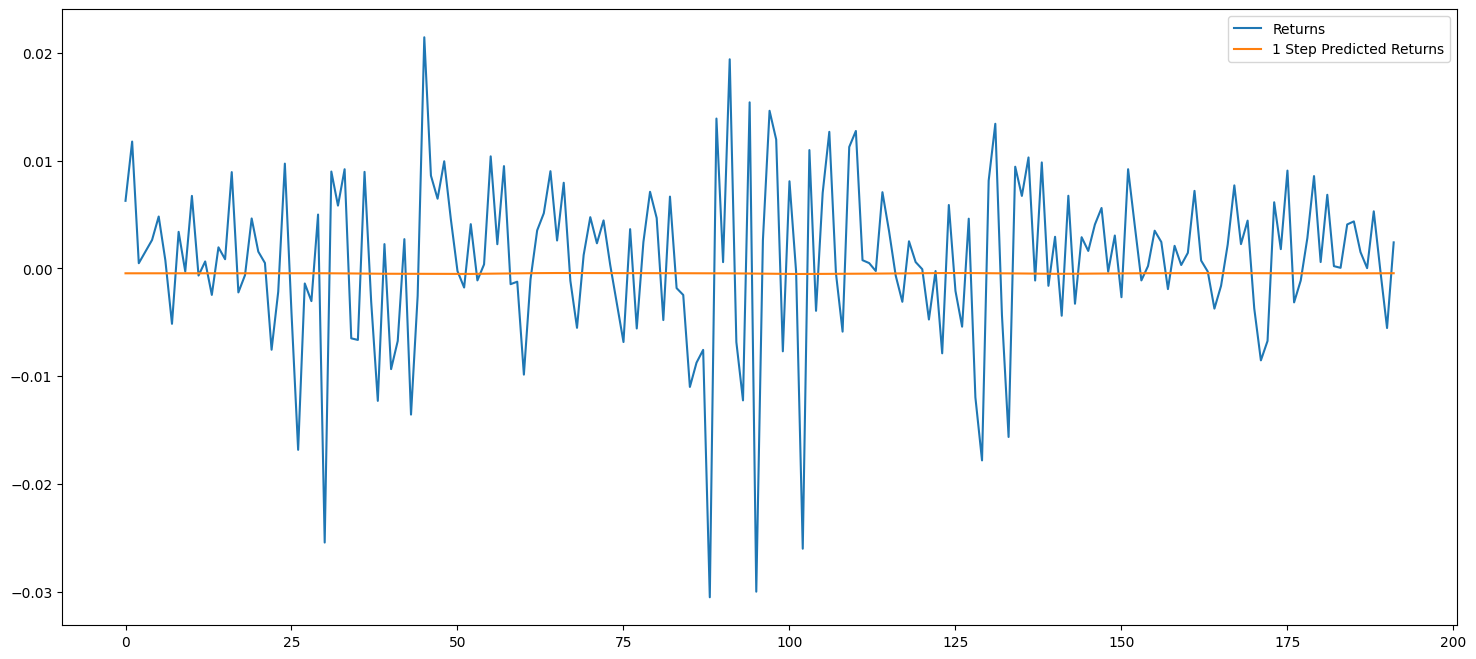

In [85]:
fig = plt.figure(figsize=(18,8))
plt.plot(np.array(spy_data["Log Returns"][split_date:][training_len:]))
plt.plot(predicted_returns)
plt.legend(["Returns", "1 Step Predicted Returns"])

## 1.2 Modelling One Step Returns Variance

### 1.2.2 Creating Training Data

In [89]:
training_len = 60
X_train = []
y_train = []

X_train = [window for window in spy_data["Realized Volatility Scaled"][:split_date][20:].rolling(window=training_len)][training_len-1:-1]
y_train = spy_data["Realized Volatility Scaled"][:split_date][20:][training_len:]
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

### 1.2.3 Forming Model

In [90]:
lstm_vol_model = Sequential()

#First Layer including dropout regularization
lstm_vol_model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1],1)))
lstm_vol_model.add(Dropout(0.3))

lstm_vol_model.add(LSTM(units=80, return_sequences=True))
lstm_vol_model.add(Dropout(0.1))

lstm_vol_model.add(LSTM(units=50, return_sequences=True))
lstm_vol_model.add(Dropout(0.2))

lstm_vol_model.add(LSTM(units=30))
lstm_vol_model.add(Dropout(0.3))

lstm_vol_model.add(Dense(units=1))

lstm_vol_model.compile(optimizer='adam',loss='mean_squared_error')

In [92]:
lstm_vol_model.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
37/37 [==============================] - 3s 75ms/step - loss: 0.0025
Epoch 2/50
37/37 [==============================] - 3s 67ms/step - loss: 0.0025
Epoch 3/50
37/37 [==============================] - 3s 83ms/step - loss: 0.0023
Epoch 4/50
37/37 [==============================] - 3s 68ms/step - loss: 0.0024
Epoch 5/50
37/37 [==============================] - 3s 77ms/step - loss: 0.0024
Epoch 6/50
37/37 [==============================] - 3s 73ms/step - loss: 0.0023
Epoch 7/50
37/37 [==============================] - 3s 74ms/step - loss: 0.0022
Epoch 8/50
37/37 [==============================] - 3s 80ms/step - loss: 0.0025
Epoch 9/50
37/37 [==============================] - 3s 89ms/step - loss: 0.0023
Epoch 10/50
37/37 [==============================] - 3s 83ms/step - loss: 0.0022
Epoch 11/50
37/37 [==============================] - 4s 103ms/step - loss: 0.0024
Epoch 12/50
37/37 [==============================] - 4s 93ms/step - loss: 0.0025
Epoch 13/50
37/37 [=================

### 1.2.4 Testing Model

In [93]:
#Making test data
X_test = []

X_test = [window for window in spy_data["Realized Volatility Scaled"][split_date:].rolling(window=training_len)][training_len-1:-1]
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_vol_transformed = lstm_vol_model.predict(X_test)
predicted_vol = vol_scaler.inverse_transform(predicted_vol_transformed)

6/6 [==============================] - 4s 45ms/step


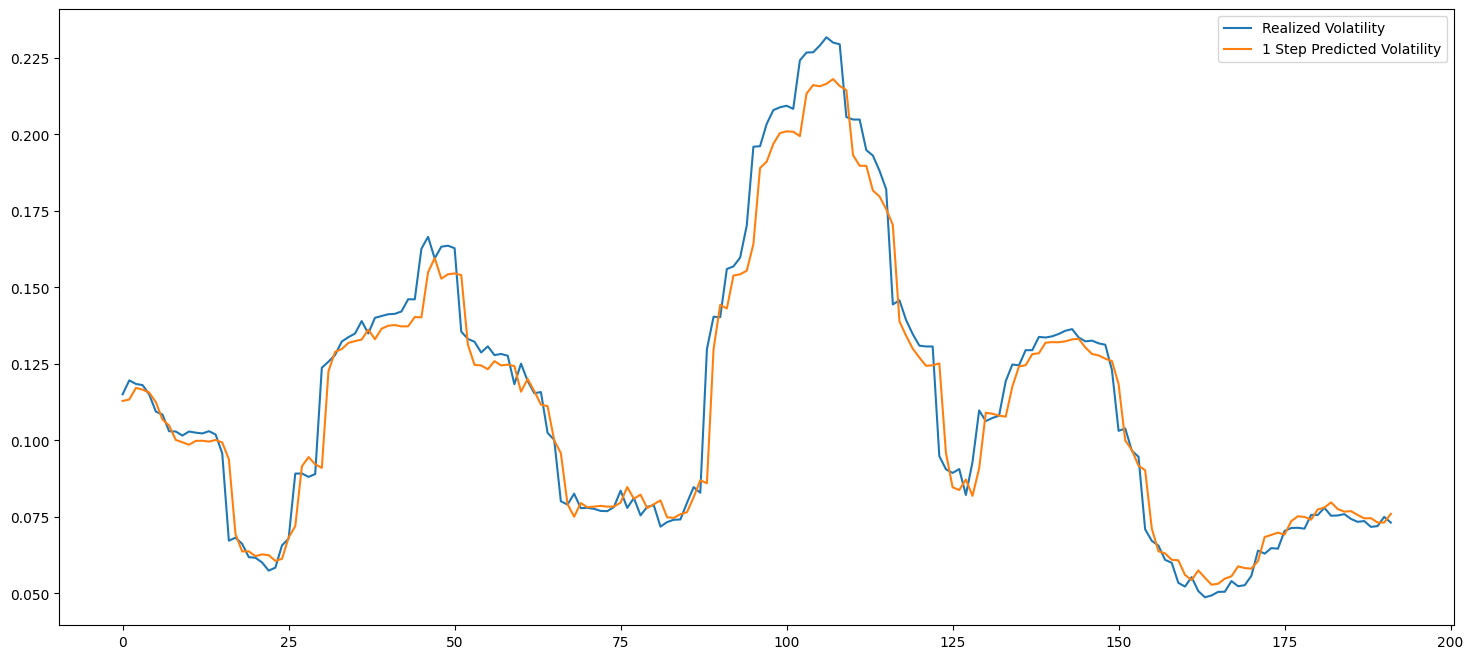

In [94]:
fig = plt.figure(figsize=(18,8))
plt.plot(np.array(spy_data["Realized Volatility"][split_date:][training_len:]))
plt.plot(predicted_vol)
plt.legend(["Realized Volatility", "1 Step Predicted Volatility"])

# 2 GRU Models 

## 2.1 Modelling One Step Mean Returns

### 2.1.2 Creating Training Data

In [106]:
training_len = 60
X_train = []
y_train = []

X_train = [window for window in spy_data["Log Returns Scaled"][:split_date].rolling(window=training_len)][training_len-1:-1]
y_train = spy_data["Log Returns Scaled"][:split_date][training_len:]
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

### 2.1.3 Forming GRU Model

In [107]:
gru_returns_model = Sequential()

#First GRU Layer
gru_returns_model.add(GRU(units=100, return_sequences=True, input_shape=(X_train.shape[1], 1), activation='tanh'))
gru_returns_model.add(Dropout(0.3))

#Second GRU Layer
gru_returns_model.add(GRU(units=80, return_sequences=True, input_shape=(X_train.shape[1], 1), activation='tanh'))
gru_returns_model.add(Dropout(0.2))

#Third GRU Layer
gru_returns_model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1), activation='tanh'))
gru_returns_model.add(Dropout(0.1))

#Fourth GRU Layer
gru_returns_model.add(GRU(units=30, activation='tanh'))
gru_returns_model.add(Dropout(0.2))

#Output Layer
gru_returns_model.add(Dense(units=1))

#Compiling RNN
gru_returns_model.compile(optimizer='adam', loss='mean_squared_error')

In [108]:
#Fitting Model
gru_returns_model.fit(X_train, y_train, epochs=50, batch_size=150)

Epoch 1/50
8/8 [==============================] - 9s 158ms/step - loss: 0.0722
Epoch 2/50
8/8 [==============================] - 1s 151ms/step - loss: 0.0195
Epoch 3/50
8/8 [==============================] - 1s 155ms/step - loss: 0.0138
Epoch 4/50
8/8 [==============================] - 1s 164ms/step - loss: 0.0132
Epoch 5/50
8/8 [==============================] - 1s 154ms/step - loss: 0.0125
Epoch 6/50
8/8 [==============================] - 1s 159ms/step - loss: 0.0118
Epoch 7/50
8/8 [==============================] - 1s 163ms/step - loss: 0.0117
Epoch 8/50
8/8 [==============================] - 1s 151ms/step - loss: 0.0113
Epoch 9/50
8/8 [==============================] - 1s 151ms/step - loss: 0.0112
Epoch 10/50
8/8 [==============================] - 2s 190ms/step - loss: 0.0118
Epoch 11/50
8/8 [==============================] - 1s 158ms/step - loss: 0.0113
Epoch 12/50
8/8 [==============================] - 1s 156ms/step - loss: 0.0108
Epoch 13/50
8/8 [==============================] 

### 2.1.4 Testing Model

In [109]:
#Making test data
X_test = []

X_test = [window for window in spy_data["Log Returns Scaled"][split_date:].rolling(window=training_len)][training_len-1:-1]
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_returns_transformed = gru_returns_model.predict(X_test)
predicted_returns = returns_scaler.inverse_transform(predicted_returns_transformed)

6/6 [==============================] - 27s 65ms/step


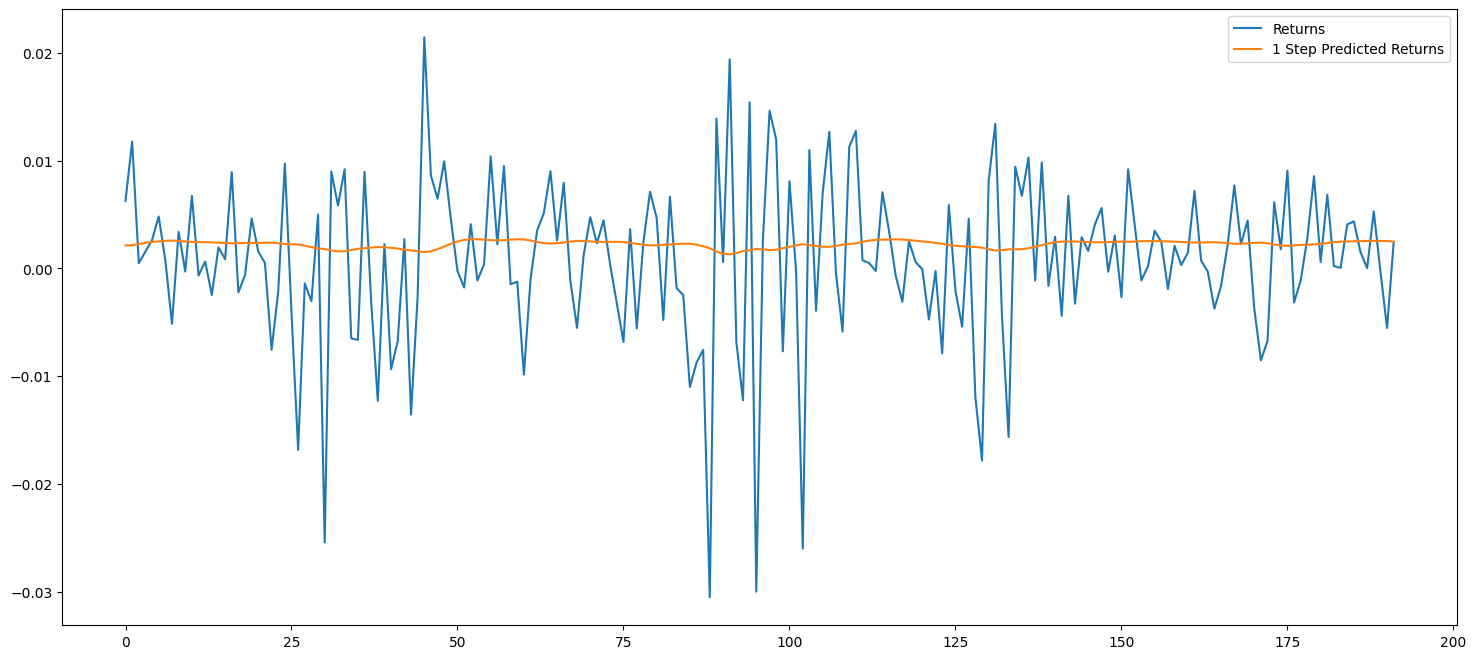

In [110]:
fig = plt.figure(figsize=(18,8))
plt.plot(np.array(spy_data["Log Returns"][split_date:][training_len:]))
plt.plot(predicted_returns)
plt.legend(["Returns", "1 Step Predicted Returns"])

## 2.2 Modelling One Step Volatility

### 2.2.2 Creating Training Data

In [100]:
training_len = 60
X_train = []
y_train = []

X_train = [window for window in spy_data["Realized Volatility Scaled"][:split_date][20:].rolling(window=training_len)][training_len-1:-1]
y_train = spy_data["Realized Volatility Scaled"][:split_date][20:][training_len:]
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

### 2.2.3 Forming GRU Model

In [101]:
gru_vol_model = Sequential()

#First GRU Layer
gru_vol_model.add(GRU(units=100, return_sequences=True, input_shape=(X_train.shape[1], 1), activation='tanh'))
gru_vol_model.add(Dropout(0.3))

#Second GRU Layer
gru_vol_model.add(GRU(units=80, return_sequences=True, input_shape=(X_train.shape[1], 1), activation='tanh'))
gru_vol_model.add(Dropout(0.2))

#Third GRU Layer
gru_vol_model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1), activation='tanh'))
gru_vol_model.add(Dropout(0.1))

#Fourth GRU Layer
gru_vol_model.add(GRU(units=30, activation='tanh'))
gru_vol_model.add(Dropout(0.2))

#Output Layer
gru_vol_model.add(Dense(units=1))

#Compiling RNN
gru_vol_model.compile(optimizer='adam', loss='mean_squared_error')

### 2.2.4 Testing Model

In [102]:
#Making test data
X_test = []

X_test = [window for window in spy_data["Realized Volatility Scaled"][split_date:].rolling(window=training_len)][training_len-1:-1]
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_vol_transformed = model.predict(X_test)
predicted_vol = vol_scaler.inverse_transform(predicted_vol_transformed)

6/6 [==============================] - 0s 26ms/step


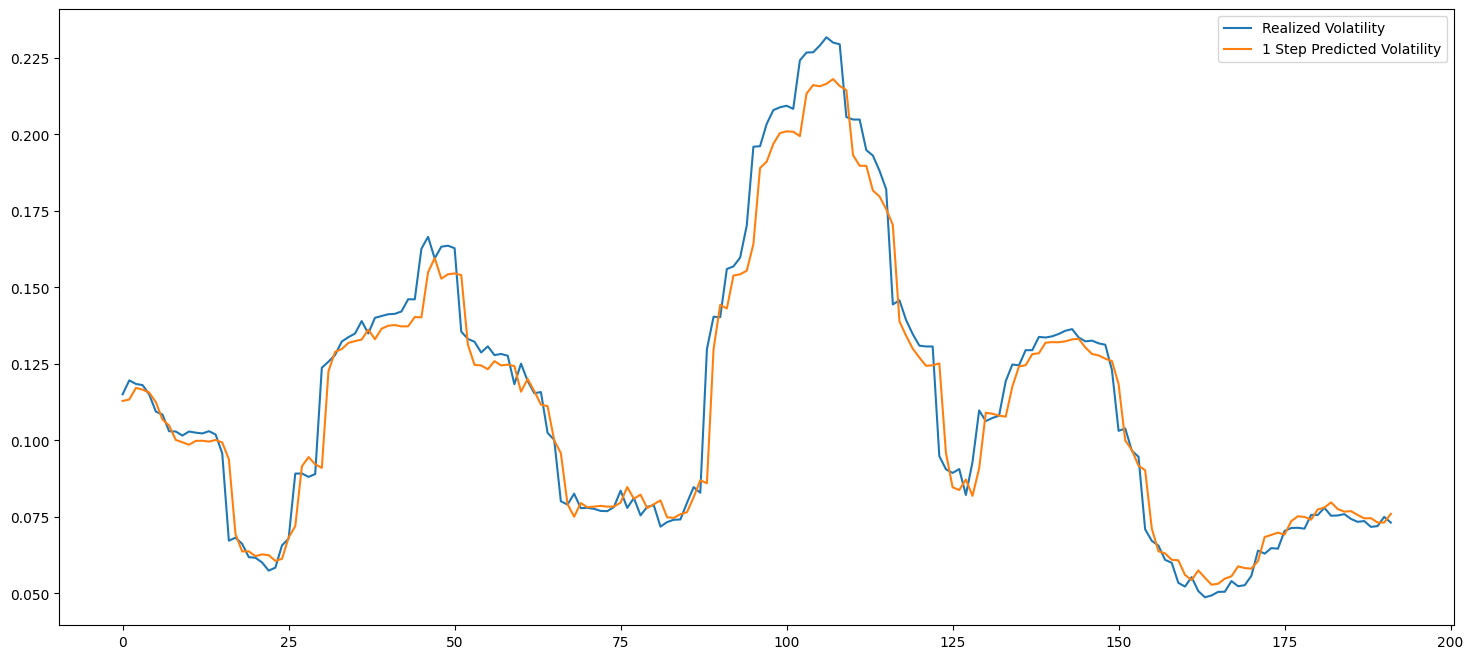

In [103]:
fig = plt.figure(figsize=(18,8))
plt.plot(np.array(spy_data["Realized Volatility"][split_date:][training_len:]))
plt.plot(predicted_vol)
plt.legend(["Realized Volatility", "1 Step Predicted Volatility"])